In [3]:
import pandas as pd
import ast
import matplotlib.pyplot as plt


In [4]:
def calculate_result(path):
    # Step 1: Load the CSV file
    df = pd.read_csv(path)

    # Step 2: Convert GIVEN_SUB_ROLES from string to list
    df["GIVEN_SUB_ROLES"] = df["GIVEN_SUB_ROLES"].apply(ast.literal_eval)

    # Step 3: Normalize text to lowercase for comparison
    df["GIVEN_MAIN_ROLE"] = df["GIVEN_MAIN_ROLE"].str.lower()
    df["PRED_M"] = df["PRED_M"].str.lower()
    df["PRED_S"] = df["PRED_S"].str.lower()
    df["GIVEN_SUB_ROLES"] = df["GIVEN_SUB_ROLES"].apply(lambda roles: [r.lower() for r in roles])

    # Step 4: Calculate correctness
    df["MAIN_CORRECT"] = df["GIVEN_MAIN_ROLE"] == df["PRED_M"]
    df["SUB_CORRECT"] = df.apply(lambda row: row["PRED_S"] in row["GIVEN_SUB_ROLES"], axis=1)

    # Step 5: Accuracy metrics
    main_accuracy = df["MAIN_CORRECT"].mean()
    sub_accuracy = df["SUB_CORRECT"].mean()

    print(f"Main Role Accuracy: {main_accuracy:.2%}")
    print(f"Sub Role Accuracy: {sub_accuracy:.2%}")

    # Step 6: Visualization
    plt.figure(figsize=(10, 5))

    # Pie for main role accuracy
    plt.subplot(1, 2, 1)
    plt.pie([main_accuracy, 1 - main_accuracy],
            labels=["Correct", "Incorrect"],
            autopct="%1.1f%%",
            colors=["green", "red"])
    plt.title("Main Role Prediction Accuracy")

    # Pie for sub role accuracy
    plt.subplot(1, 2, 2)
    plt.pie([sub_accuracy, 1 - sub_accuracy],
            labels=["Correct", "Incorrect"],
            autopct="%1.1f%%",
            colors=["blue", "orange"])
    plt.title("Sub Role Prediction Accuracy")

    # Step 7: Save the figure
    plt.tight_layout()

# The {entity} is an instance of {}.

Main Role Accuracy: 54.55%
Sub Role Accuracy: 18.88%


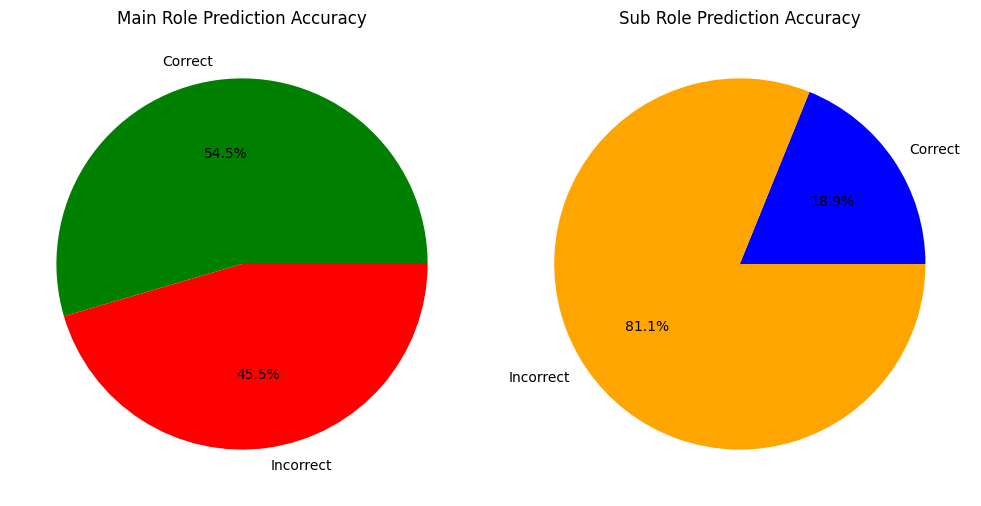

In [5]:
calculate_result("resources/bart_main_sub.csv")

# {entity} has a role of {{}} in this text.

Main Role Accuracy: 44.41%
Sub Role Accuracy: 24.48%


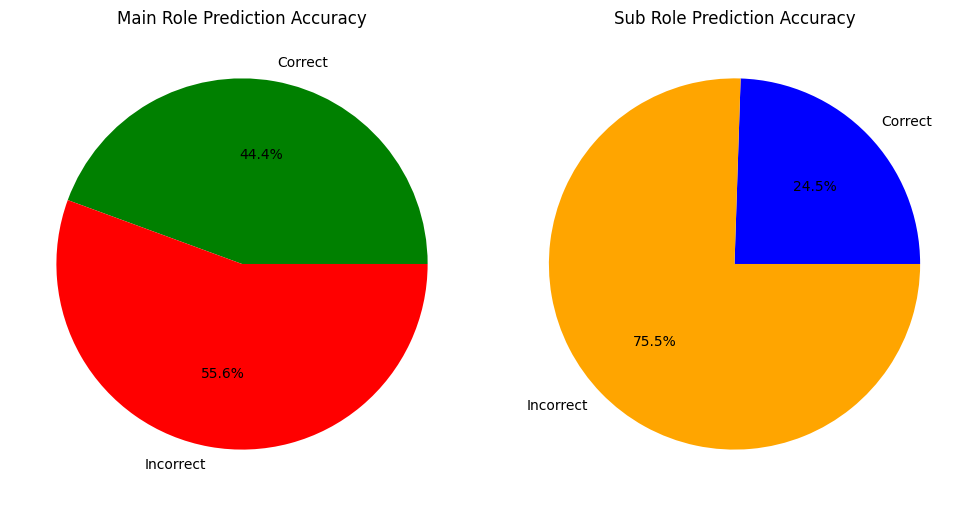

In [6]:
calculate_result("resources/bart_main_sub_second_template.csv")

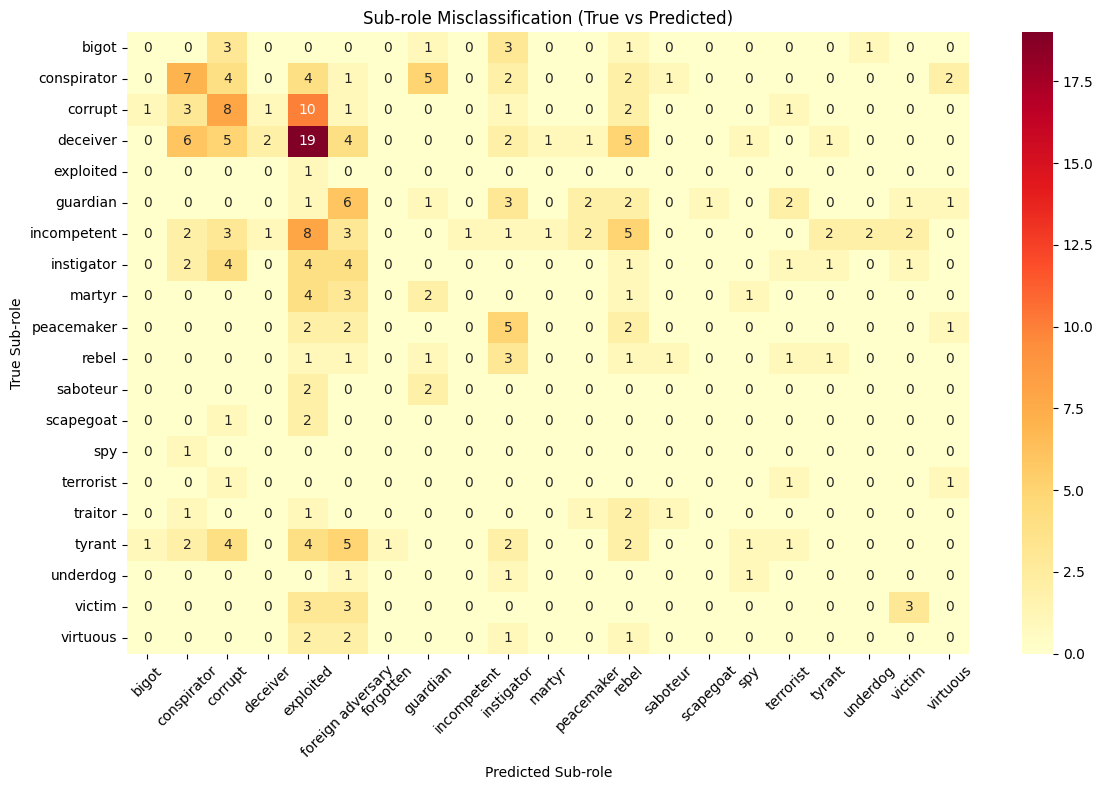

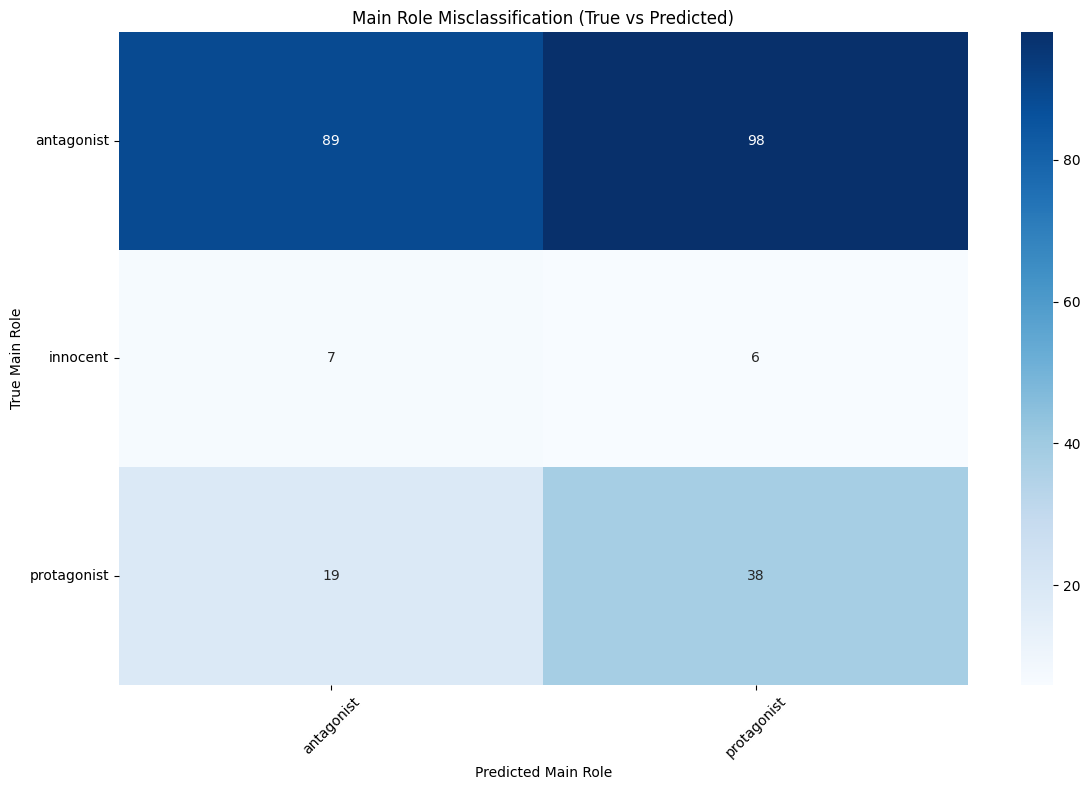

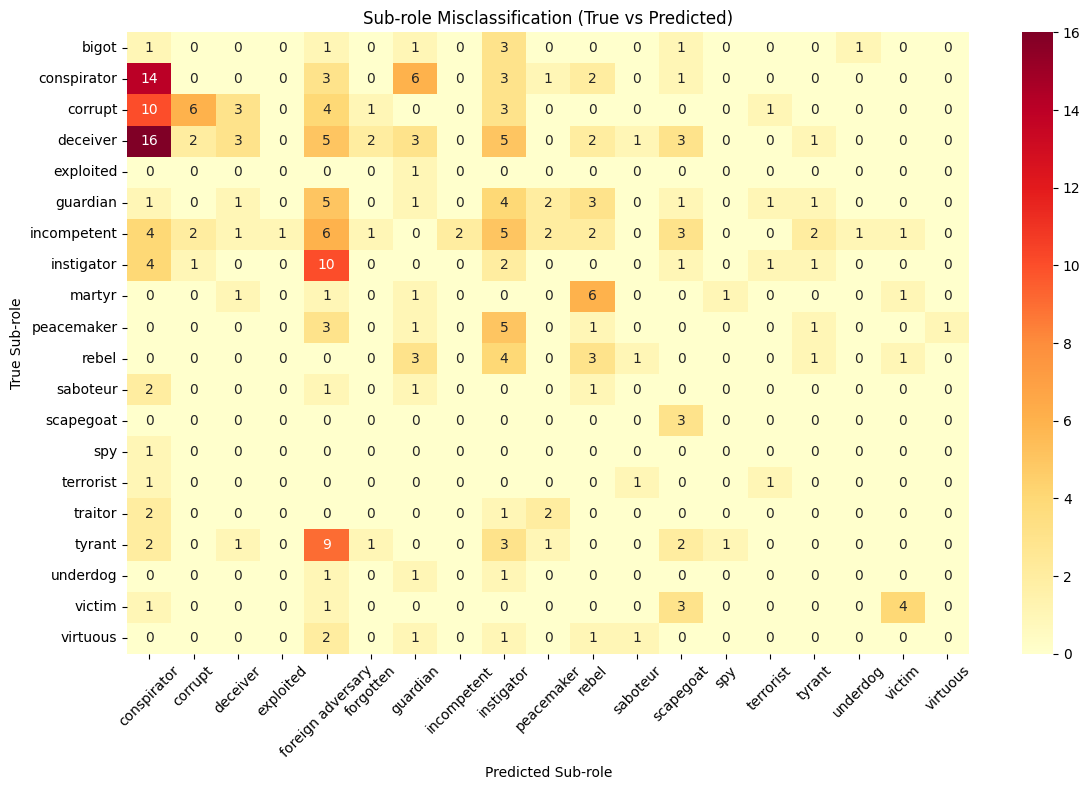

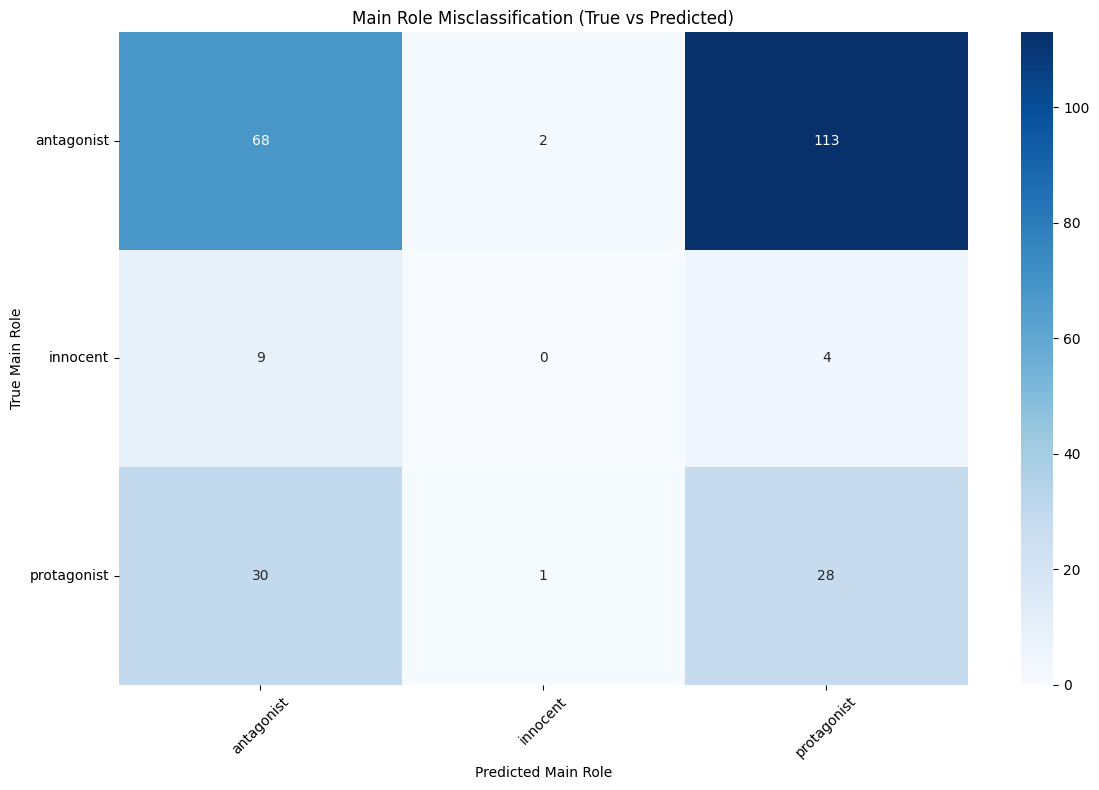

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast

def visualize_confusion_matrices(path):
    # Load and preprocess data
    df = pd.read_csv(path)
    df["GIVEN_SUB_ROLES"] = df["GIVEN_SUB_ROLES"].apply(ast.literal_eval)
    df["GIVEN_MAIN_ROLE"] = df["GIVEN_MAIN_ROLE"].str.lower()
    df["PRED_M"] = df["PRED_M"].str.lower()
    df["PRED_S"] = df["PRED_S"].str.lower()
    df["GIVEN_SUB_ROLES"] = df["GIVEN_SUB_ROLES"].apply(lambda roles: [r.lower() for r in roles])

    # Check correctness
    df["MAIN_CORRECT"] = df["GIVEN_MAIN_ROLE"] == df["PRED_M"]
    df["SUB_CORRECT"] = df.apply(lambda row: row["PRED_S"] in row["GIVEN_SUB_ROLES"], axis=1)
    df["INCORRECT"] = ~df["MAIN_CORRECT"] | ~df["SUB_CORRECT"]
    incorrect_df = df[df["INCORRECT"]]

    ### ----- SUB-ROLE CONFUSION MATRIX ----- ###
    sub_pairs = []
    for _, row in incorrect_df.iterrows():
        for true_sub in row["GIVEN_SUB_ROLES"]:
            sub_pairs.append((true_sub, row["PRED_S"]))

    sub_df = pd.DataFrame(sub_pairs, columns=["True Sub-role", "Predicted Sub-role"])
    sub_matrix = pd.crosstab(sub_df["True Sub-role"], sub_df["Predicted Sub-role"])

    plt.figure(figsize=(12, 8))
    sns.heatmap(sub_matrix, annot=True, fmt="d", cmap="YlOrRd")
    plt.title("Sub-role Misclassification (True vs Predicted)")
    plt.xlabel("Predicted Sub-role")
    plt.ylabel("True Sub-role")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    ### ----- MAIN ROLE CONFUSION MATRIX ----- ###
    main_matrix = pd.crosstab(incorrect_df["GIVEN_MAIN_ROLE"], incorrect_df["PRED_M"])

    plt.figure(figsize=(12, 8))
    sns.heatmap(main_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Main Role Misclassification (True vs Predicted)")
    plt.xlabel("Predicted Main Role")
    plt.ylabel("True Main Role")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Example usage:
visualize_confusion_matrices("resources/bart_main_sub.csv")
visualize_confusion_matrices("resources/bart_main_sub_second_template.csv")


# {entity} is {{}}

In [12]:
import pandas as pd

from transformers import pipeline
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")


Device set to use mps:0


In [13]:

candidate_main_labels = ['protagonist', 'innocent', 'antagonist']
candidate_sub_roles = [
    "Guardian", "Martyr", "Peacemaker", "Rebel", "Underdog", "Virtuous", "Instigator", 
    "Conspirator", "Tyrant", "Foreign Adversary", "Traitor", "Spy", "Saboteur", "Corrupt", 
    "Incompetent", "Terrorist", "Deceiver", "Bigot", "Forgotten", "Exploited", "Victim", "Scapegoat"
]

In [ ]:

def classify_and_save(input_path, output_path):
    df = pd.read_csv(input_path)
    rows = []

    for idx, row in df.iterrows():
        article_id = row["ARTICLE_ID"]
        entity = row["ENTITY"]
        given_role = row["GIVEN_MAIN_ROLE"]
        g_sub_roles = row["GIVEN_SUB_ROLES"]
        context = row["CONTEXT"]

        main_result = classifier(
            context,
            candidate_main_labels,
            hypothesis_template=f"{entity} is {{}}."
        )

        sub_result = classifier(
            context,
            candidate_sub_roles,
            hypothesis_template=f"{entity} is {{}}."
        )

        main_pred = main_result['labels'][0]
        sub_pred = sub_result['labels'][0]

        rows.append({
            "ARTICLE_ID": article_id,
            "ENTITY": entity,
            "GIVEN_MAIN_ROLE": given_role,
            "GIVEN_SUB_ROLES": g_sub_roles,
            "PRED_M": main_pred,
            "PRED_S": sub_pred,
            "CONTEXT": context
        })

    output = pd.DataFrame(rows)
    output.to_csv(output_path, index=False)


In [ ]:

classify_and_save("resources/bart_main_sub_second_template.csv", "resources/entity_is_label.csv")

Main Role Accuracy: 43.71%
Sub Role Accuracy: 18.88%


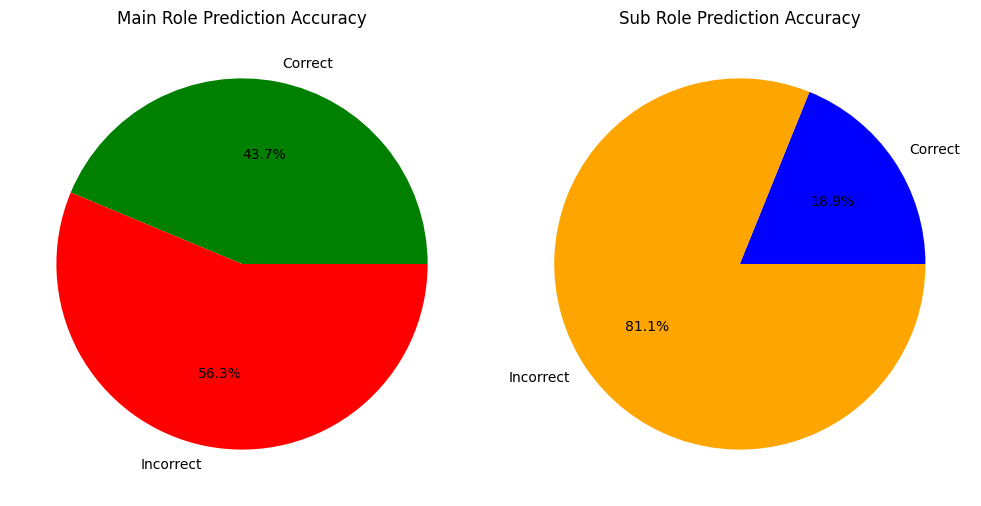

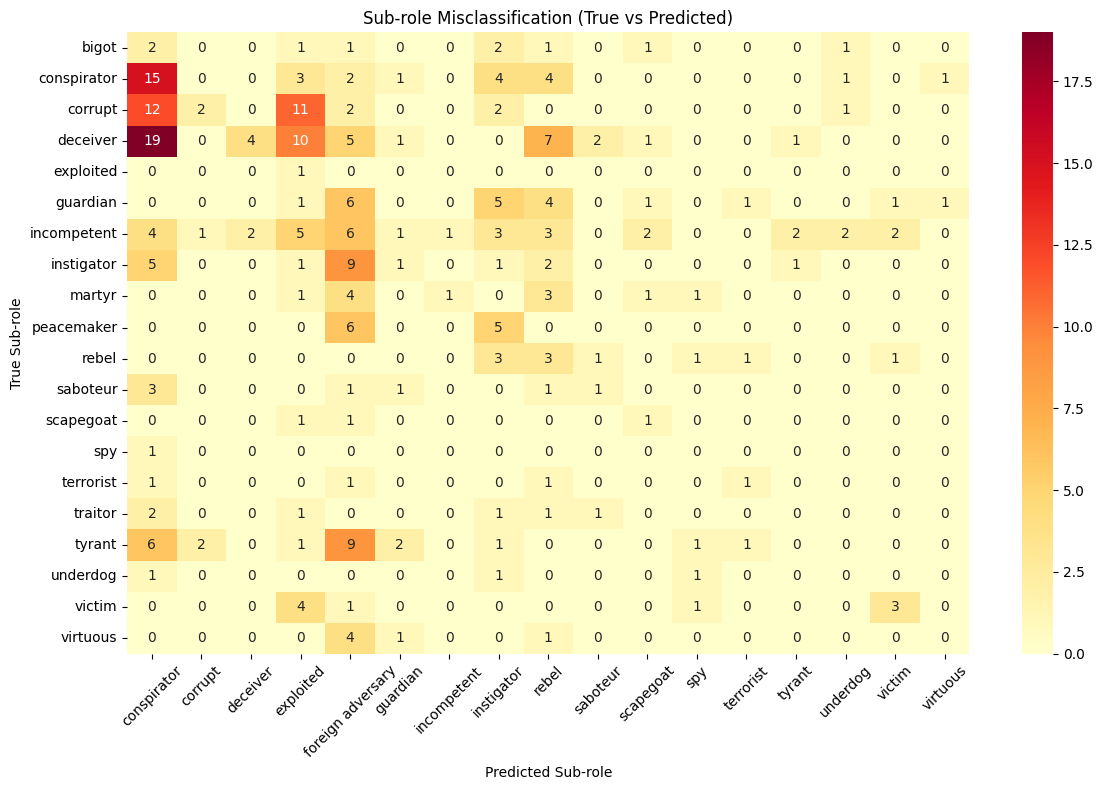

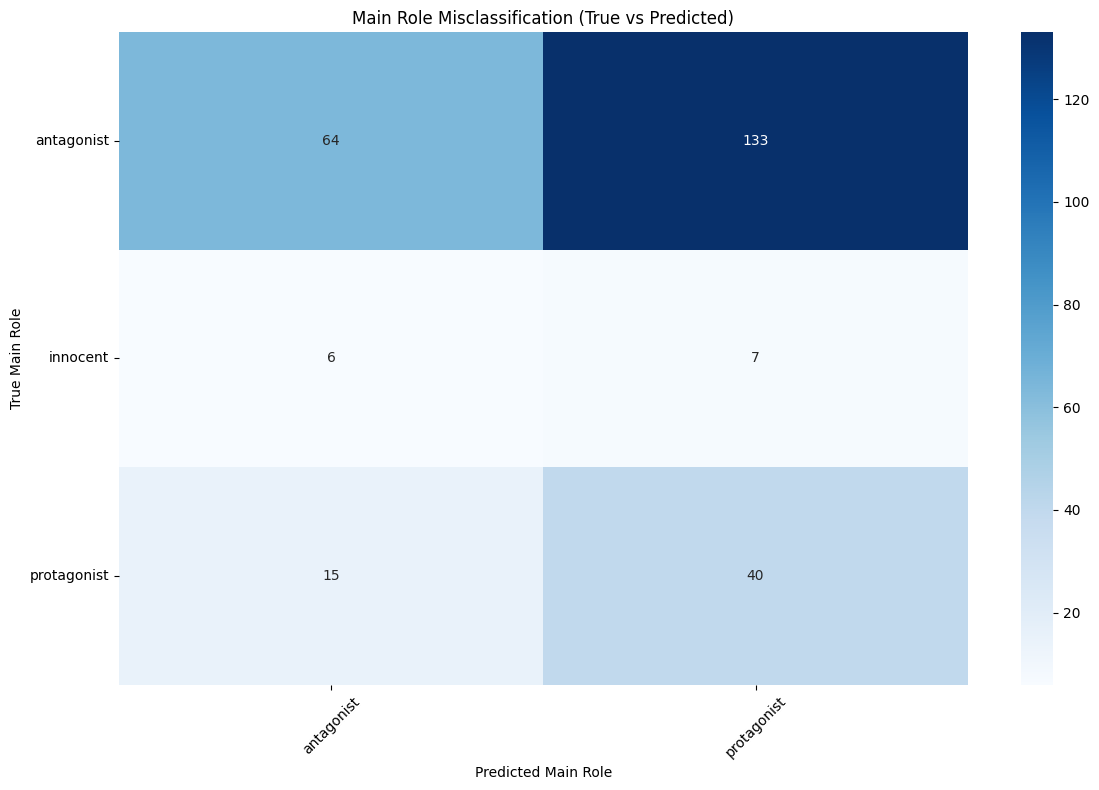

In [16]:
calculate_result("resources/entity_is_label.csv")
visualize_confusion_matrices("resources/entity_is_label.csv")